In [2]:
# Nonlinear dynamics JC
# 2D nonlinear system example (slow points or ghost of fixed points)
# AK, July-8-2022
# =========================================================================
%reset -f
import os, sys
import numpy as np
import pandas as pd
from numpy import linalg as ln
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize
from jax import jacfwd, jacrev
import jax.numpy as jnp
from pprint import pprint

# Define paths 
DIR_HERE = os.path.dirname(os.path.realpath("__file__"))

# Define local functions
def hessian(f): return jacfwd(jacrev(f))

%who

DIR_HERE	 hessian	 integrate	 jacfwd	 jacrev	 jnp	 ln	 np	 optimize	 
os	 pd	 plt	 pprint	 scipy	 sys	 


In [9]:
# ANALYSIS 0: Set up a dynamical system
# ========================

# Define functions of a dynamical system (2 dimensional)
a = -.3 # .3 or -.3
def f1(x1, x2, a): return(x2 - (x1 ** 2 + 1/4 + a)) # function 1
def f2(x1, x2, a): return(x1 - x2) # function 2 (a is not used here)

# Define functions for minima detection
def dyn_2d(xs): return([f(xs[0], xs[1], a) for f in list([f1, f2])]) # apply f1 and d2 to x1 and x2
def qf(Fx): return(.5 * ln.norm(Fx) ** 2) # q(x) = EQ3.5(Succillo and Barak, 2012)


In [ ]:
# Note about analytic solution 
# WIP


In [10]:
# ANALYSIS 1: Phase space
# ========================

# Define range of (arbitrary) phase space
x1_r = np.linspace(-4, 4, 200)
x2_r = np.linspace(-4, 4, 100)
q = np.zeros((len(x1_r),len(x2_r)))
Js = list()

# Loop over the entire phase space to get q
# small qs are fixed poitns 
for d1_i, x1 in enumerate(x1_r):
    for d2_i, x2 in enumerate(x2_r):
        # Get output of f1 and f2
        xsets = np.array([x1, x2])
        Fx = dyn_2d(xsets)
        
        # Compute the norm of dynamics q(x)
        q[d1_i, d2_i] = qf(Fx)
        
        # Compute Jacobian
        #J = jacfwd(dyn_2d)(xsets)
        #J.append(np.array(J))
        
# q contains norm 
print(q)

[[199.00125    197.39565873 195.80312736 ... 104.06575362 103.72697187
  103.40125   ]
 [192.66941668 191.08643478 189.51651278 ...  99.92702889  99.6108565
   99.307744  ]
 [186.50401418 184.94338045 183.39580662 ...  95.92939941  95.6355752
   95.35481087]
 ...
 [217.8607981  215.66669399 213.48564978 ...  65.83955626  64.91226166
   63.99802695]
 [224.34780864 222.12485923 219.91496971 ...  69.52857195  68.57243205
   67.62935204]
 [231.00125    228.74919409 226.51019807 ...  73.35868292  72.37343651
   71.40125   ]]


In [11]:
# ANALYSIS 2: Optimization to find minima
# ========================
# Define optimization related variables
nrepeat = 2000
pic = np.random.choice
minima = np.zeros((nrepeat, 2))

# Run optimization with randomly picked initial conditions
for i in range(nrepeat):
    IC = [pic(x1_r), pic(x2_r)]
    r = optimize.minimize(lambda x: qf(dyn_2d(x)), IC)
    minima[i,:] = r['x'] if r['success'] else None
  
# Ignore small differences and get unique minimas
minima = np.unique(np.round(minima, 3), axis=0) 
print("Fixed points (x1, x2): \n", minima)

Fixed points (x1, x2): 
 [[-0.048 -0.048]
 [ 1.048  1.048]]


In [7]:
# ANALYSIS 3: Jacobian & Hessian
# ========================
J_EV = []

for i in range(minima.shape[0]):
    # Calculate Jacobian matrix 
    J = jacfwd(dyn_2d)(minima[i,:])
    J = np.array(J)
    print("Jacobian:\n", J, "\n")

    # Do eigendecomposition of J
    J_eigval, J_eigvec = ln.eig(J)
    print("Eigenvector of J:\n", J_eigvec, "\n")
    print("Eigenvalue of J:\n", J_eigval, "\n")

    # Calculate Hessian matrix 
    H = hessian(dyn_2d)(minima[i,:])
    H = np.array(H)
    #print("Hessian:\n", H, "\n")
    
    # Keep it
    J_EV.append(J_eigvec)


Jacobian:
 [[-1.  1.]
 [ 1. -1.]] 

Eigenvector of J:
 [[ 0.70710677 -0.70710677]
 [ 0.70710677  0.70710677]] 

Eigenvalue of J:
 [ 0. -2.] 



In [12]:
# # Testing Jaccobian detection (using polar cordinate transformation)
# # Define functions of a dynamical system (2 dimensional)
# def f1_t(r, theta): return(r * jnp.cos(theta)) 
# def f2_t(r, theta): return(r * jnp.sin(theta)) 
# def fun_t(r_theta): return([f(r_theta[0], r_theta[1]) for f in list([f1_t, f2_t])]) 

# # Jacobian
# i = jnp.array([2, 2], dtype='float32')
# J = jacfwd(fun_t)(i)
# J = np.array(J)
# print("Jacobian:\n", J, "\n")

# # Validation (analytic solution)
# # [cos(theta), -r*sin(theta); sin(theta), r*cos(theta)]
# def validate (i): return (np.array([np.cos(i[1]), -i[0] * np.sin(i[1]),
#                                     np.sin(i[1]), i[0] * np.cos(i[1])]).reshape([2, 2]))

# print("Jacobian (analytic): \n", validate(i),"\n")


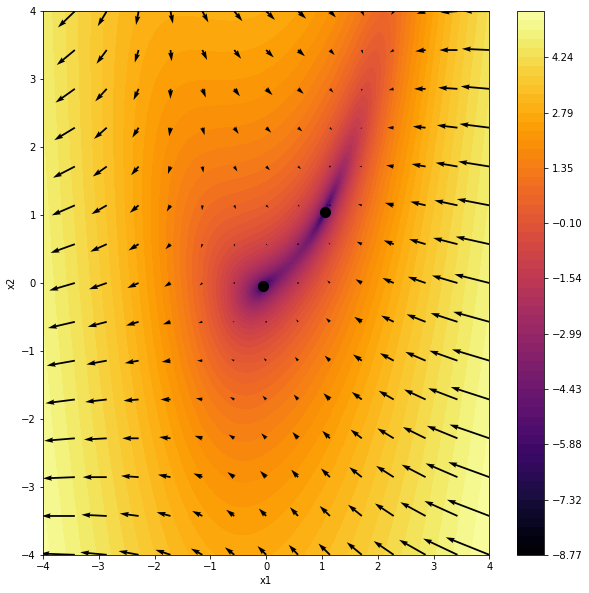

In [13]:
# ANALYSIS N: Plotting
# ========================

# Plot results!
fig, ax = plt.subplots(figsize=(10, 10))

# Contours
Z = np.log(q) # original q values
# Z = something else to check?
X1, X2 = np.meshgrid(x2_r, x1_r)
levels = np.linspace(Z.min(), Z.max(), 60)
contourf_ = ax.contourf(X2, X1, Z, levels=levels)
contourf_.set_cmap('inferno')
cbar = fig.colorbar(contourf_)

# Plot small q points
plt.scatter(minima[:, 0], minima[:, 1], color = "black", marker="o", s = 100)

# Plot vector field
X1, X2 = np.meshgrid(np.linspace(-4, 4, 15), np.linspace(-4, 4, 15))
plt.quiver(X1, X2, f1(X1, X2, a), f2(X1, X2, a))

# Plot of fixed points
# plt.quiver(*minima[0, :], *J_EV[0][1], color=['b'])

# Labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()